In this notebook I will show how to create MLP model that is capable of determining whether movie review is negative or positive. I will use **bag of words** technique.

### Import

In [1]:
!pip install -q keras
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from keras.datasets import imdb

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import os
import random as rn
import numpy as np

# Randomness control
os.environ['PYTHONHASHSEED'] = '0'
RANDOM_SEED = 3939
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, 
                              inter_op_parallelism_threads=1)

tf.set_random_seed(RANDOM_SEED)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
keras.backend.set_session(sess)

Using TensorFlow backend.


### Constants

In [0]:
SKIP_WORDS = 20
DICT_SIZE = 15000

### Load Data
IMDB data is being built into ``from keras.datasets`` module.
We will be skipping top 20 used words from dictionary and using vector representing 15000 first words of dictionary.

In [3]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(
    num_words=DICT_SIZE, skip_top=SKIP_WORDS)

17465344/17464789 [==============================] - 1s 0us/step


### Data Visualisation

Loading dictionary.

In [4]:
word_to_index = imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


Displaying top 20 words.

In [5]:
index_to_word = dict([[v,k] for k,v in word_to_index.items()])
words_to_show = 20

for rating in range(0, words_to_show):
  if rating in index_to_word.keys():
    print(rating, index_to_word[rating])


1 the
2 and
3 a
4 of
5 to
6 is
7 br
8 in
9 it
10 i
11 this
12 that
13 was
14 as
15 for
16 with
17 movie
18 but
19 film


Decoding reviews by dict.

In [6]:
def decode(encoded_text, word_to_index):
  word_to_index_cpy = word_to_index.copy()
  word_to_index_cpy = {k:(v+3) for k,v in word_to_index_cpy.items()}
  word_to_index_cpy["<PAD>"] = 0
  word_to_index_cpy["<START>"] = 1
  word_to_index_cpy["<UNK>"] = 2

  id_to_word = {value:key for key,value in word_to_index_cpy.items()}
  return ' '.join(id_to_word[id] for id in encoded_text)

reviews_to_show = 10
for review_id in range(reviews_to_show):
  print("Review no {}:".format(review_id))
  print("  - encoded: {}".format(X_train[review_id]))
  print("  - decoded: {}".format(decode(X_train[review_id], word_to_index)))

Review no 0:
  - encoded: [2, 2, 22, 2, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 2, 173, 36, 256, 2, 25, 100, 43, 838, 112, 50, 670, 2, 2, 35, 480, 284, 2, 150, 2, 172, 112, 167, 2, 336, 385, 39, 2, 172, 4536, 1111, 2, 546, 38, 2, 447, 2, 192, 50, 2, 2, 147, 2025, 2, 2, 22, 2, 1920, 4613, 469, 2, 22, 71, 87, 2, 2, 43, 530, 38, 76, 2, 2, 1247, 2, 22, 2, 515, 2, 2, 2, 626, 2, 2, 2, 62, 386, 2, 2, 316, 2, 106, 2, 2, 2223, 5244, 2, 480, 66, 3785, 33, 2, 130, 2, 2, 38, 619, 2, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 2, 22, 2, 215, 28, 77, 52, 2, 2, 407, 2, 82, 10311, 2, 2, 107, 117, 5952, 2, 256, 2, 2, 2, 3766, 2, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 2, 2, 12118, 1029, 2, 104, 88, 2, 381, 2, 297, 98, 32, 2071, 56, 26, 141, 2, 194, 7486, 2, 2, 226, 22, 21, 134, 476, 26, 480, 2, 144, 30, 5535, 2, 51, 36, 28, 224, 92, 25, 104, 2, 226, 65, 2, 38, 1334, 88, 2, 2, 283, 2, 2, 4472, 113, 103, 32, 2, 2, 5345, 2, 178, 32]
  - decoded: <UNK> <UNK> film <UNK> just brilliant casting lo

### Data Preprocessing

Create input vectors of size DICT_SIZE, where each position represents top word from `word_to_index` dict. If word in sentence is present in dictionary then position representing this word is marked as 1.0 otherwise 0.0.

In [7]:
def vectorize_sequences(word_vectors, dim=DICT_SIZE):
  results = np.zeros((len(word_vectors), dim))
  for i, vec in enumerate(word_vectors):
    results[i, vec] = 1.0
  return results

print("Before vectorization X_train: {}".format(X_train.shape))
print("Before vectorization X_test: {}".format(X_test.shape))

X_train = vectorize_sequences(X_train)
X_test = vectorize_sequences(X_test)

print("After vectorization X_train: {}".format(X_train.shape))
print("After vectorization X_test: {}".format(X_test.shape))

Before vectorization X_train: (25000,)
Before vectorization X_test: (25000,)
After vectorization X_train: (25000, 15000)
After vectorization X_test: (25000, 15000)


In [8]:
print(X_train[0])

[0. 0. 1. ... 0. 0. 0.]


### Train/Validation data split

In [9]:
split_ratio = 0.8
split_index = int(X_train.shape[0] * split_ratio)

X_train_input, y_train_input = X_train[:split_index], y_train[:split_index]
X_val_input, y_val_input = X_train[split_index:], y_train[split_index:]

print("X_train_input shape: {}".format(X_train_input.shape))
print("y_train_input shape: {}".format(y_train_input.shape))
print("X_val_input shape: {}".format(X_val_input.shape))
print("y_val_input shape: {}".format(y_val_input.shape))

X_train_input shape: (20000, 15000)
y_train_input shape: (20000,)
X_val_input shape: (5000, 15000)
y_val_input shape: (5000,)


In [10]:
print("Train data shape: {}".format(X_train_input.shape))
print("Validation data shape {}".format(X_val_input.shape))
print("Test data shape: {}".format(X_test.shape))

Train data shape: (20000, 15000)
Validation data shape (5000, 15000)
Test data shape: (25000, 15000)


### Model

Creation

In [11]:
model = Sequential()

model.add(Dense(32,  
                input_shape=(DICT_SIZE,), 
                kernel_initializer=glorot_uniform(seed=RANDOM_SEED),
                use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.8))

model.add(Dense(12,  
                kernel_initializer=glorot_uniform(seed=RANDOM_SEED),
                use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(1, 
                activation="sigmoid",
                kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))
    
model.compile(loss="binary_crossentropy", optimizer=Adam(0.0007), 
              metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                480000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                384       
_________________________________________________________________
batch_normalization_2 (Batch (None, 12)                48        
_________________________________________________________________
activation_2 (Activation)    (None, 12)                0         
__________

Training

In [12]:
history = model.fit(X_train_input, y_train_input,
                    batch_size=16,
                    epochs=16,
                    verbose=2,
                    validation_data=(X_val_input, y_val_input))

Train on 20000 samples, validate on 5000 samples
Epoch 1/16
 - 14s - loss: 0.6494 - acc: 0.6354 - val_loss: 0.4892 - val_acc: 0.8328
Epoch 2/16
 - 13s - loss: 0.5130 - acc: 0.7583 - val_loss: 0.3852 - val_acc: 0.8700
Epoch 3/16
 - 13s - loss: 0.4516 - acc: 0.8052 - val_loss: 0.3410 - val_acc: 0.8794
Epoch 4/16
 - 13s - loss: 0.4084 - acc: 0.8314 - val_loss: 0.3038 - val_acc: 0.8850
Epoch 5/16
 - 13s - loss: 0.3786 - acc: 0.8481 - val_loss: 0.2924 - val_acc: 0.8878
Epoch 6/16
 - 13s - loss: 0.3722 - acc: 0.8519 - val_loss: 0.2900 - val_acc: 0.8892
Epoch 7/16
 - 13s - loss: 0.3506 - acc: 0.8624 - val_loss: 0.2778 - val_acc: 0.8926
Epoch 8/16
 - 13s - loss: 0.3428 - acc: 0.8665 - val_loss: 0.2826 - val_acc: 0.8900
Epoch 9/16
 - 13s - loss: 0.3170 - acc: 0.8806 - val_loss: 0.2758 - val_acc: 0.8932
Epoch 10/16
 - 13s - loss: 0.3210 - acc: 0.8786 - val_loss: 0.2778 - val_acc: 0.8924
Epoch 11/16
 - 13s - loss: 0.3151 - acc: 0.8803 - val_loss: 0.2783 - val_acc: 0.8896
Epoch 12/16
 - 13s - loss

In [13]:
train_score = model.evaluate(X_train_input, y_train_input, verbose=0)
val_score = model.evaluate(X_val_input, y_val_input, verbose=0)
test_score = model.evaluate(X_test, y_test, verbose=0)
  
train_score, train_accuracy = train_score
print("Train data results:")
print(" - error: {}".format(train_score))
print(" - acc: {}".format(train_accuracy))

val_score, val_accuracy = val_score
print("Validation data results:")
print(" - error: {}".format(val_score))
print(" - acc: {}".format(val_accuracy))

test_score, test_accuracy = test_score
print("Test data results:")
print(" - error: {}".format(test_score))
print(" - acc: {}".format(test_accuracy))

Train data results:
 - error: 0.1025254687011242
 - acc: 0.97865
Validation data results:
 - error: 0.28121648137569427
 - acc: 0.8884
Test data results:
 - error: 0.3007185688972473
 - acc: 0.87904


Evaluation

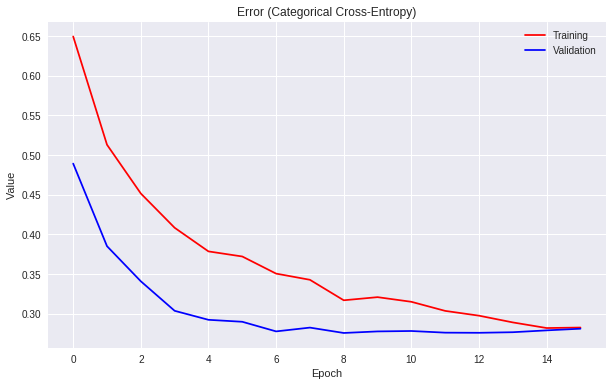

In [14]:
f, ax = plt.subplots()
f.set_size_inches(10, 6)
    
ax.plot(history.history["loss"], c="r")
ax.plot(history.history["val_loss"], c="b")
ax.set_title("Error (Categorical Cross-Entropy)")
ax.set_ylabel("Value")
ax.set_xlabel("Epoch")
ax.legend(["Training", "Validation"], loc="best");